In [1]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Reshape, Flatten, Activation
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import ReLU, LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.utils import multi_gpu_model

import keras
import keras.backend as K
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf

import shutil, os, sys, io, random, math
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from PIL import Image
from tqdm import tqdm

os.chdir('/home/k_yonhon/py/Keras-GAN/pggan/')
sys.path.append(os.pardir)

from tensor_board_logger import TensorBoardLogger
from wasserstein_loss import WassersteinLoss, GradientPenaltyLoss

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
KTF.set_session(session)

# ---------------------
#  Parameter
# ---------------------
gpu_count = 4
dataset = np.load('../datasets/lfw128.npz')['arr_0']

In [2]:
class WGANGP():
    def __init__(self, dataset, gpu_count=1):
        # ---------------------
        #  Parameter
        # ---------------------
        self.dataset = dataset
        self.gpu_count = gpu_count
                
        self.img_rows = dataset.shape[1]
        self.img_cols = dataset.shape[2]
        self.channels = dataset.shape[3]
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        self.input_rows = 4
        self.input_cols = 4
        self.latent_dim = 128  # Noise dim
        
        self.n_critic = 5
        self.λ = 10        
        optimizer = Adam(lr=0.0001, beta_1=0., beta_2=0.9, epsilon=None, decay=0.0, amsgrad=False)

        # ---------------------
        #  for TensorBoard
        # ---------------------
        target_dir = "./my_log_dir"
        shutil.rmtree(target_dir, ignore_errors=True)
        os.mkdir(target_dir)
        self.logger = TensorBoardLogger(log_dir=target_dir)

        # ---------------------
        #  Load models
        # ---------------------
        self.critic = self.build_critic()
        self.generator = self.build_generator()
        
        #  Load pretrained weights        
        pre_gen = load_model('./saved_model/wgangp64_gen_model_3k.h5')
        for i, layer in enumerate(self.generator.layers[1].layers):
            if i in [i for i in range(1, int(math.log(self.img_rows / self.input_rows, 2)) * 2, 2)]:
                layer.set_weights(pre_gen.layers[1].layers[i].get_weights())
                layer.trainable = False
                
        pre_critic = load_model('./saved_model/wgangp64_critic_model_3k.h5')
        for i, layer in enumerate(self.critic.layers[1].layers):
            j = i - len(self.critic.layers[1].layers)
            if j in [-i for i in range(int(math.log(self.img_rows / self.input_rows, 2)) * 2, 0, -2)]:
                layer.set_weights(pre_critic.layers[1].layers[j].get_weights())
                layer.trainable = False

        #-------------------------------
        # Compile Critic
        #-------------------------------    
        generated_samples = Input(shape=self.img_shape) 
        critic_output_from_generated_samples = self.critic(generated_samples)
        
        real_samples = Input(shape=self.img_shape)        
        critic_output_from_real_samples = self.critic(real_samples)

        averaged_samples = Input(shape=self.img_shape)
        critic_output_from_averaged_samples = self.critic(averaged_samples)

        partial_gp_loss = partial(GradientPenaltyLoss,
                                  averaged_samples=averaged_samples,
                                  gradient_penalty_weight=self.λ)
        # Functions need names or Keras will throw an error
        partial_gp_loss.__name__ = 'gradient_penalty'

        self.critic_model = Model(inputs=[generated_samples, 
                                          real_samples,
                                          averaged_samples],
                                  outputs=[critic_output_from_generated_samples, 
                                           critic_output_from_real_samples,
                                           critic_output_from_averaged_samples])
        if self.gpu_count > 1:
            self.critic_model = multi_gpu_model(self.critic_model, gpus=self.gpu_count)
        self.critic_model.compile(optimizer=optimizer, 
                                  loss=[WassersteinLoss, 
                                        WassersteinLoss, 
                                        partial_gp_loss])
        
        print('Critic Summary:')
        self.critic.summary()       
        
        #-------------------------------
        # Compile Generator
        #-------------------------------
        # For the generator we freeze the critic's layers
        self.critic.trainable = False
                    
        generator_input = Input(shape=(self.latent_dim,))
        generator_layers = self.generator(generator_input)
        critic_layers_for_generator = self.critic(generator_layers)
        
        self.generator_model = Model(inputs=[generator_input], 
                                     outputs=[critic_layers_for_generator])
        if self.gpu_count > 1:
            self.generator_model = multi_gpu_model(self.generator_model, gpus=self.gpu_count)
        self.generator_model.compile(optimizer=optimizer,
                                     loss=WassersteinLoss)        

        print('Genarator Summary:')
        self.generator.summary()   

    def build_generator(self):
        model = Sequential()
        model.add(Reshape((self.input_rows, self.input_cols, int(self.latent_dim / (self.input_rows * self.input_cols))), 
                          input_shape=(self.latent_dim,)
                         ))

        model.add(Conv2DTranspose(512, (3, 3), strides=1, padding='same',
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        model.add(LeakyReLU(alpha=0.2))      

        for _ in range(int(math.log(self.img_rows / self.input_rows, 2))):
            model.add(Conv2DTranspose(512, (3, 3), strides=2, padding='same', 
                                     kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                     ))
            model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(256, (3, 3), strides=1, padding='same', 
                                  kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                  ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(128, (3, 3), strides=1, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(64, (3, 3), strides=1, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(32, (3, 3), strides=1, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(16, (3, 3), strides=1, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(3, (3, 3), strides=1, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))                
        model.add(Activation("tanh"))

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)
    
    def build_critic(self):
        model = Sequential()
        model.add(Conv2D(16, (1, 1), strides=1, input_shape=self.img_shape, padding="valid",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(32, (3, 3), strides=1, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(64, (3, 3), strides=1, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(128, (3, 3), strides=1, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(256, (3, 3), strides=1, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(512, (3, 3), strides=1, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))

        for _ in range(int(math.log(self.img_rows / self.input_rows, 2))):
            model.add(Conv2D(512, (3, 3), strides=2, padding="same",
                             kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                            ))
            model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(1, (4, 4), strides=1, padding="valid",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(Flatten())

        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)
    
    def train(self, epochs, batch_size, sample_interval=5000, resume=0):
        # Load suspended training weights
        if resume != 0:
            self.critic = load_model('./saved_model/wgangp'+str(self.img_rows)+'_critic_model_'+str(resume)+'epoch.h5')
            self.generator = load_model('./saved_model/wgangp'+str(self.img_rows)+'_gen_model_'+str(resume)+'epoch.h5')
        
        # Rescale the dataset -1 to 1 
        X_train = self.dataset / 127.5 - 1.0

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1), dtype=np.float32)
        fake = np.ones((batch_size, 1), dtype=np.float32)
        dummy = np.zeros((batch_size, 1), dtype=np.float32)

        # ---------------------
        #  Training
        # ---------------------
        for epoch in tqdm(range(resume, resume + epochs + 1)):
            for _ in range(self.n_critic):
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_imgs = self.generator.predict(noise, batch_size=batch_size)
                
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                real_imgs = X_train[idx]
                               
                ε = np.random.uniform(size=(batch_size, 1,1,1))
                ave_imgs = ε * real_imgs + (1-ε) * gen_imgs
                
                # Train Critic
                d_loss = self.critic_model.train_on_batch([gen_imgs, real_imgs, ave_imgs], 
                                                          [fake, valid, dummy])

            # Train Generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.generator_model.train_on_batch(noise, valid)

            # ---------------------
            #  Logging
            # ---------------------
            # Backup Model
            if epoch != resume and (epoch % 1000 == 0 or epoch % sample_interval == 0):
                self.critic.save('./saved_model/wgangp'+str(self.img_rows)+'_critic_model_'+str(epoch)+'epoch.h5')
                self.generator.save('./saved_model/wgangp'+str(self.img_rows)+'_gen_model_'+str(epoch)+'epoch.h5')
            
            # Log Loss & Histgram
            logs = {
                "loss/Critic": d_loss[0],
                "loss/Generator": g_loss,
                "loss_Critic/D_gen": d_loss[1],
                "loss_Critic/D_real": -d_loss[2],
                "loss_Critic/gradient_penalty": d_loss[3],
                "loss_Critic/total_loss": d_loss[1] + d_loss[2] + d_loss[3],                
            }

            histograms = {}
            for layer in self.critic.layers[1].layers:
                for i in range(len(layer.get_weights())):
                    if "conv" in layer.name or "dense" in layer.name:
                        name = layer.name + "/" + str(i)
                        value = layer.get_weights()[i]
                        histograms[name] = value
            
            self.logger.log(logs=logs, histograms=histograms, epoch=epoch)
            
            # Log generated image samples
            if epoch == 1000 or epoch == 2000 or epoch % sample_interval == 0:
                fig, name = self.sample_images(epoch)
                images = {name: fig}
                self.logger.log(images=images, epoch=epoch)
                print("%d [C loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))

    def sample_images(self, epoch):
        r, c = 2, 2
        if epoch == 0:
            idx = np.random.randint(0, self.dataset.shape[0], r * c)
            imgs = self.dataset[idx].astype(np.uint8)
            name = "original.png"
        else:
            noise = np.random.normal(0, 1, (r * c, self.latent_dim))
            imgs = self.generator.predict(noise, batch_size=r * c)
            imgs = ((0.5 * imgs + 0.5) * 255).astype(np.uint8) # Rescale images 0 - 255
            name = str(epoch) + ".png"        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                if self.channels == 1:
                    axs[i, j].imshow(imgs[cnt, :, :, 0], cmap="gray")
                else:
                    axs[i, j].imshow(imgs[cnt, :, :, :self.channels], cmap="gray")
                axs[i, j].axis("off")
                cnt += 1
        return fig, name

In [3]:
wgan = WGANGP(dataset, gpu_count)

/home/k_yonhon/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Critic Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 13379617  
Total params: 13,379,617
Trainable params: 3,932,192
Non-trainable params: 9,447,425
_________________________________________________________________
Genarator Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128)               0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 128, 128, 3)       13408675  
Total params: 13,408,675
Trainable params: 3,932,067
Non-trainable params: 9,476,608
_________________________________________________________________


  0%|          | 0/1501 [00:00<?, ?it/s]/home/k_yonhon/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  0%|          | 1/1501 [01:44<43:24:27, 104.18s/it]

1500 [C loss: -2.700613] [G loss: 47.106155]


  7%|▋         | 101/1501 [39:18<8:43:57, 22.46s/it]

1600 [C loss: -6.942205] [G loss: -95.960281]


 13%|█▎        | 201/1501 [1:16:38<8:05:47, 22.42s/it]

1700 [C loss: -10.889747] [G loss: -145.595886]


 20%|██        | 301/1501 [1:53:48<7:20:29, 22.02s/it]

1800 [C loss: -6.062734] [G loss: -242.203583]


 27%|██▋       | 401/1501 [2:31:16<6:53:06, 22.53s/it]

1900 [C loss: -18.860296] [G loss: -152.068054]


 33%|███▎      | 501/1501 [3:08:34<6:17:40, 22.66s/it]

2000 [C loss: -10.459189] [G loss: -139.220810]


 40%|████      | 601/1501 [3:46:08<5:34:41, 22.31s/it]

2100 [C loss: -19.568453] [G loss: -228.774780]


 47%|████▋     | 701/1501 [4:23:30<5:00:56, 22.57s/it]

2200 [C loss: -14.694952] [G loss: -212.096771]


 53%|█████▎    | 801/1501 [5:01:05<4:24:05, 22.64s/it]

2300 [C loss: -17.678211] [G loss: -251.009827]


 60%|██████    | 901/1501 [5:38:32<3:42:55, 22.29s/it]

2400 [C loss: -19.694691] [G loss: -222.338638]


 67%|██████▋   | 1001/1501 [6:15:44<3:05:41, 22.28s/it]

2500 [C loss: -20.442841] [G loss: -231.744934]


 73%|███████▎  | 1101/1501 [6:53:11<2:29:25, 22.41s/it]

2600 [C loss: -23.193150] [G loss: -205.183121]


 80%|████████  | 1201/1501 [7:30:35<1:54:14, 22.85s/it]

2700 [C loss: -27.709698] [G loss: -216.943359]


 87%|████████▋ | 1301/1501 [8:08:18<1:14:45, 22.43s/it]

2800 [C loss: -18.227390] [G loss: -244.353745]


 93%|█████████▎| 1401/1501 [8:45:42<37:27, 22.48s/it]

2900 [C loss: -11.348008] [G loss: -222.999146]


100%|██████████| 1501/1501 [9:23:05<00:00, 22.63s/it]

3000 [C loss: -19.803839] [G loss: -246.032959]


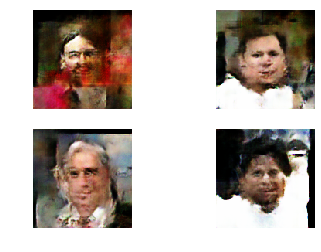

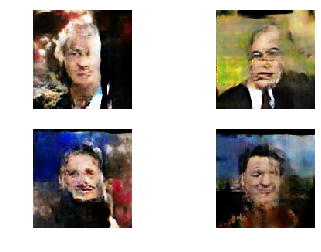

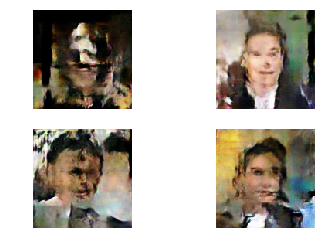

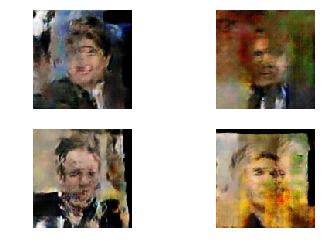

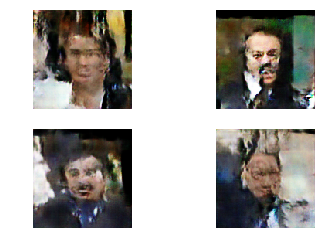

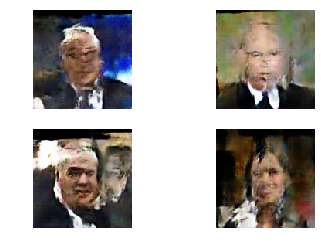

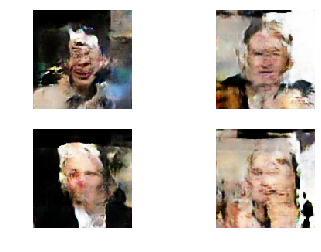

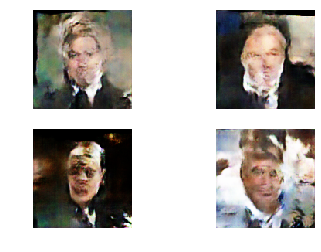

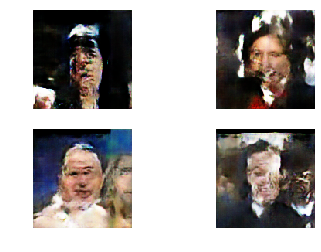

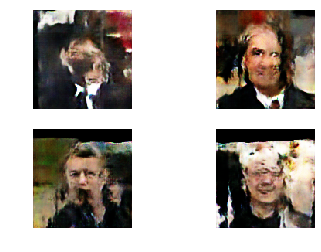

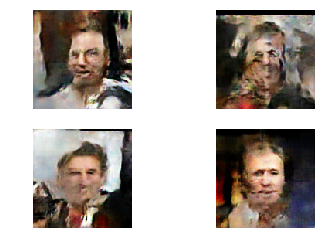

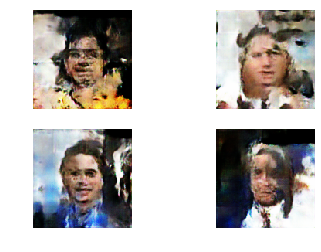

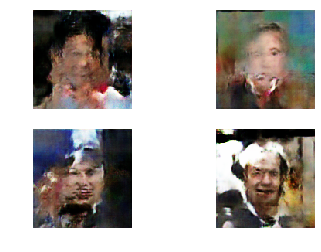

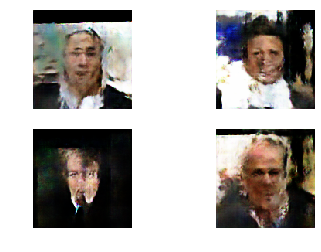

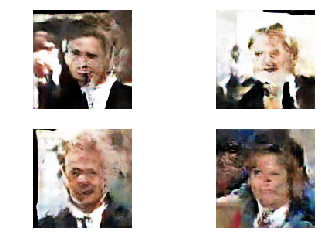

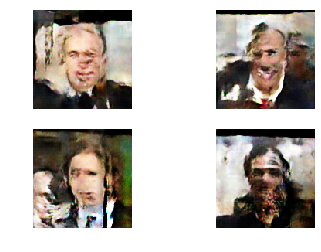

In [4]:
wgan.train(epochs=2000, batch_size=64, sample_interval=500, resume=0)

In [ ]:
wgan.generator.save('./saved_model/wgangp128_gen_model.h5')
wgan.critic.save('./saved_model/wgangp128_critic_model.h5')